
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./heatpipe.ipynb" download="heatpipe.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=heatpipe.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/bilke/ogs/-/blob/web-versioning/Tests/Data/Parabolic/ThermalTwoPhaseFlowPP/HeatPipe/heatpipe.py"><img src="https://img.shields.io/static/v1?label=Source:&message=heatpipe.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Parabolic/ThermalTwoPhaseFlowPP/HeatPipe/heatpipe.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

## Introduction

When an unsaturated porous medium is subject to a constant heat flux and the temperature is sufficiently high, water is heated and vaporizes.
Vapor flows under its pressure gradient towards the cooler end where it condenses.
Vaporization and condensation produce a liquid saturation gradient, creating a capillary pressure gradient inside the porous medium.
Condensate flows towards the hot end under the influence of a capillary pressure gradient.
This is a heat pipe in an unsaturated porous medium.

A benchmark regarding the heat pipe problem was proposed by Udell and Fitch (1985).
A semi-analytical solution was provided for a non-isothermal water-gas system in a porous medium, in which heat convection, conduction, and latent heat transport as well as capillary effects play a key role.

## Physical Scenario

As shown in the below figure, the heat pipe was represented by a 2D horizontal column (2.4 m in length and 0.2 m in width) of porous media, which was partially saturated with a liquid phase ($S_w$ = 0.41) at the beginning.
A heater is installed on the right-hand-side of the horizontal column generating a constant heat flux of 100 $\mathrm{W/m^2}$ and raises the temperature gradually above the boiling point.
At the left-hand boundary, we impose the constant gas phase pressure ($P_g$ = 101934 Pa), constant liquid saturation ($S_w$ = 0.97) and constant temperature ($T = 343 K = 70 ^\circ C$) as Dirichlet boundary conditions.

![Model domain](./figures/model_domain.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

## Model parameters and numerical settings

In this benchmark, the thermal conductivity for an unsaturated medium is given as:
\begin{equation}
    \lambda(S_w)=\lambda_{S_w=0}+\sqrt {S_w}\left(\lambda_{S_w = 1}-\lambda_{S_w = 0})\right.
\end{equation}
The capillary pressure is dependent on the liquid saturation via the Leverett (Leverett et al. (1941)) function:
\begin{equation}
        P_c(S_w)=\sqrt{\frac{\phi}{K}}\gamma\left(1.417(1-S_w)-2.12(1-S_w)^2+1.263(1-Sw)^3)\right.
\end{equation}
where $\gamma$ = 0.05878 N/m stands for the surface tension of water. The relative permeabilities are calculated using the Udell (Udell and Fitch (1985)) model:
\begin{equation}
    k_{rL}=S_w^3,
\end{equation}
\begin{equation}
    k_{rG}=(1-S_w)^3.
\end{equation}
The rest of the parameters used in this benchmark are listed in the following table.

| Parameter | Value | Unit |
| :-: | :-: | :-: |
| Intrinsic permeability $K$ | 1e-12 | m$^2$ |
| Porosity                                        $\phi$          | 0.4                 |   -                     |
| Thermal conductivity of dry porous medium       $\lambda_{S_w=0}$ | 0.582               | W/m/K   |
| Thermal conductivity of saturated porous medium $\lambda_{S_w=1}$ | 1.14                | W/m/K  |
| Specific heat capacity of soil grain            $c_{p,s}$       | 700                 | J/kg/K   |
| Specific heat capacity of air                   $c_{v,a}$       | 733                 | J/kg/K   |
| Specific heat capacity of water                 $c_{p,w}$       | 4187                | J/kg/K   |
| Density of water                                $\rho_w$        |1000                | kg/m$^3$          |
| Density of soil grain                           $\rho_s$        | 2650                | kg/m$^3$          |
| Dynamic viscosity of the liquid phase           $\mu_{L}$       | 2.938e-4  | Pa s                |
| Dynamic viscosity of the gas phase              $\mu_{G}$       | 1.8e-5   | Pa s                |
| Diffusion coefficient in free gas               $D_{0a}$        | 2.6e-6  | m$^2$/s         |
| Diffusion coefficient in free water             $D_{0w}$        | 3.0e-9   | m$^2$/s           |
| Latent heat of water vaporization               $h_{\Delta e}$  | 2.258e6   | J/kg          |


## Results and analysis

We first will define the key output variables in the OGSTools context.
Doing so makes it easier to call OGSTools built-in high-level plotting and analysis functions in the next steps.

In [2]:
saturation = ot.variables.saturation.replace(data_name="saturation")
temperature = ot.variables.temperature.replace(output_unit="K")
pressure = ot.variables.pressure.replace(
    data_name="gas_pressure", output_name="Gas pressure", output_unit="Pa", symbol="P_g"
)

In the CTEST-small, the comparison is made for the time of 10000 seconds.
The profiles of saturation and temperature are plotted below.

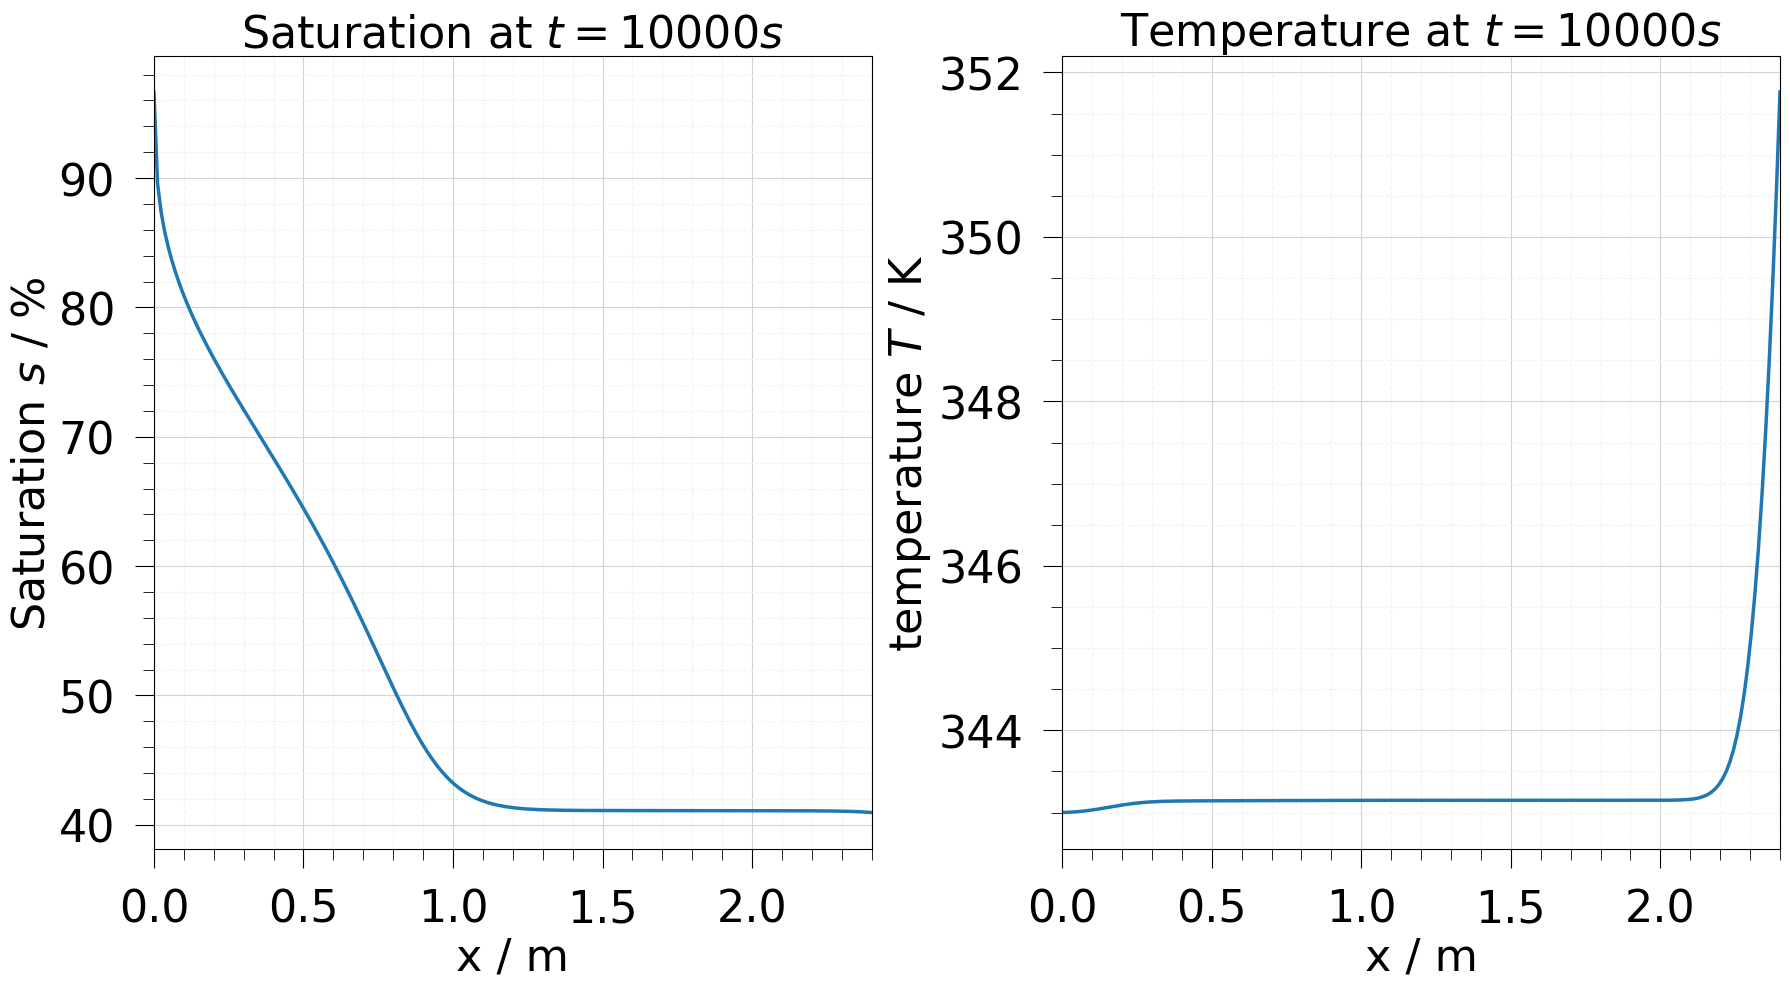

In [3]:
probe_points = np.column_stack(
    (np.arange(0, 0.012 * 201, 0.012), np.full(201, 0.1), np.zeros(201))
)

ms = ot.MeshSeries("ref_t_10000.000000.vtu")
ms_saturation = ot.MeshSeries.extract_probe(
    ms, probe_points, saturation.replace(output_unit="")
)
ms_temperature = ot.MeshSeries.extract_probe(ms, probe_points, temperature)

fig, ax = plt.subplots(figsize=(18, 10), ncols=2)

ot.plot.line(ms_saturation, saturation, ax=ax[0])
ot.plot.line(ms_temperature, temperature, ax=ax[1])

ax[0].set_title("Saturation at $t = 10000s$")
ax[1].set_title("Temperature at $t = 10000s$")
_ = [a.set_xlim(0, 2.4) for a in ax]
ot.plot.utils.update_font_sizes(ax)
fig.tight_layout()

In the CTEST-large, the comparison is made for the time of 1.4e6 seconds.
Around this time, the water is fully evaporated from the heating boundary (right hand side), and single phase zone of gas phase is formulated, while the temperature at this part begins to increase significantly, as shown below.

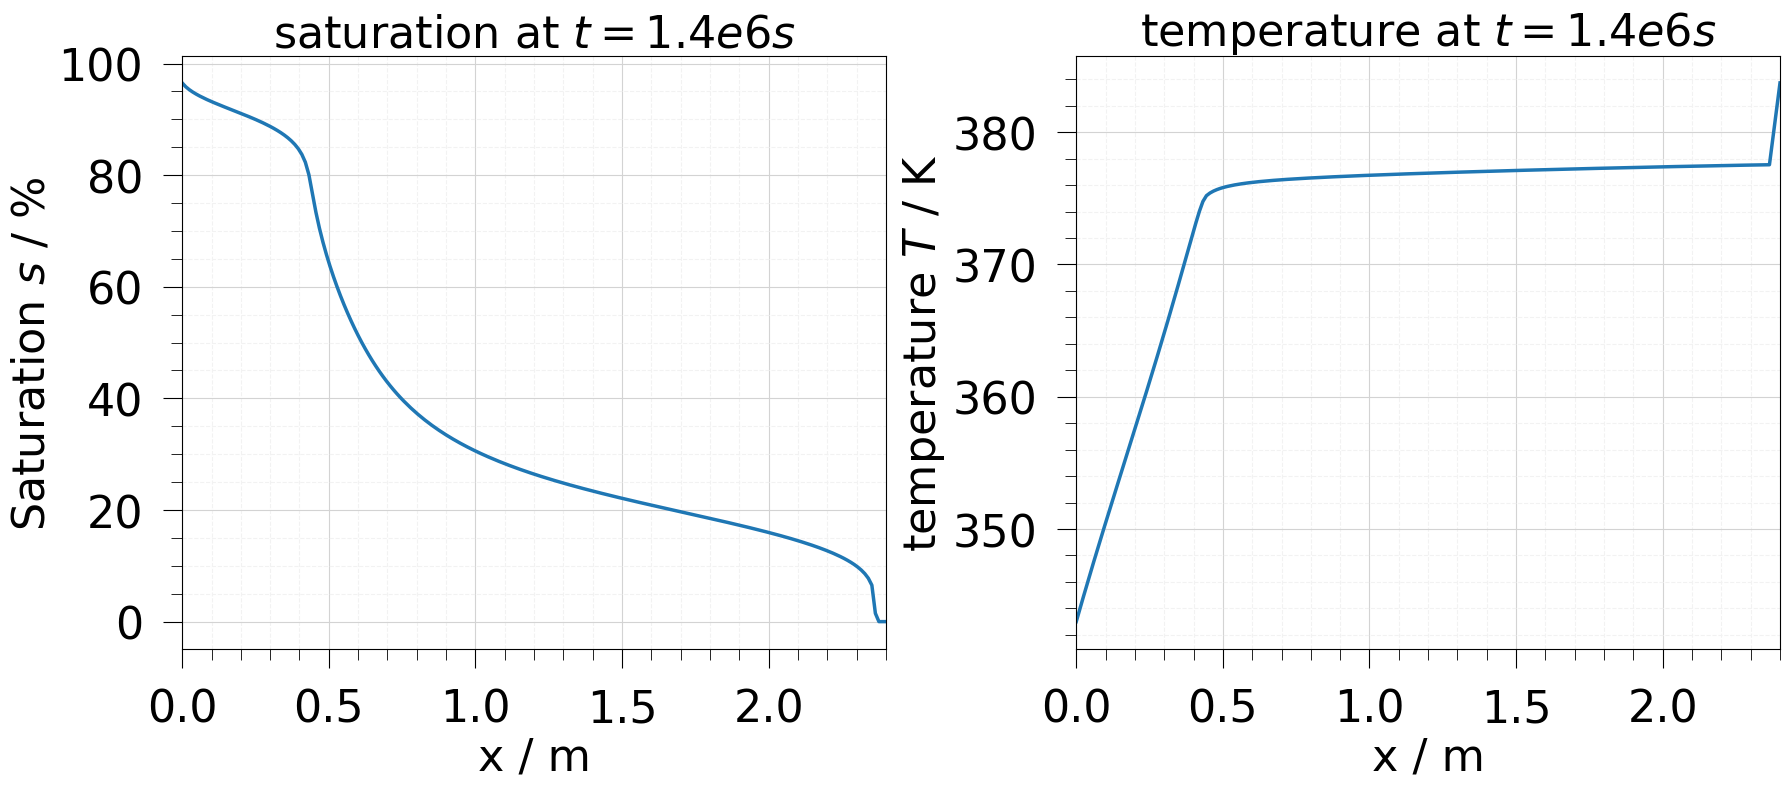

In [4]:
ms = ot.MeshSeries("ref_t_1400000.000000.vtu")
ms_saturation = ot.MeshSeries.extract_probe(
    ms, probe_points, saturation.replace(output_unit="")
)
ms_temperature = ot.MeshSeries.extract_probe(ms, probe_points, temperature)

fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ot.plot.line(ms_saturation, saturation, ax=ax[0])
ot.plot.line(ms_temperature, temperature, ax=ax[1])

ax[0].set_title("saturation at $t = 1.4e6s$")
ax[1].set_title("temperature at $t = 1.4e6s$")
_ = [a.set_xlim(0, 2.4) for a in ax]
ot.plot.utils.update_font_sizes(ax)
fig.tight_layout()

After the gas phase appearance, it is recommended to change to an adaptive time stepping scheme (e.g. Evolutionary PID Controller or Iteration Number Based) to assure the numerical stability.
In the case of Iteration Number Based Time Stepping, the time step size is kept around 175 s with 4.5 iterations on average.

For the steady-state solution of this problem, a semi-analytical solution was derived by Udell and Fitch (1985) and extended by Huang et al. (2015).
Here we provide the semi-analytical solution as a <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ThermalTwoPhaseFlowPP/HeatPipe/SemianalyticalSolutionHeatPipe.zip">MATLAB script</a> which enables us to compute the steady-state gas pressure, saturation and temperature profiles along the $x$-direction (see calculated values in <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ThermalTwoPhaseFlowPP/HeatPipe/SemianalyticalSolutionResults.csv">SemianalyticalSolutionResults.csv</a>).
In the following, the numerical solution by OpenGeoSys at quasi-steady state ($t$ = 2e7 s) is plotted against the semi-analytical solution for comparison. In addition, the absolute and relative errors are also illustrated.

In [5]:
semi_ana_solution = pd.read_csv(
    "SemianalyticalSolutionResults.csv",
    sep=",",
    header=None,
    skiprows=0,
    names=["x", "saturation", "temperature", "pressure"],
    index_col=False,
)

results = ot.MeshSeries("ref_steady_status.vtu")

In [6]:
results_saturation = ot.MeshSeries.extract_probe(
    results, probe_points, saturation.replace(output_unit="")
)

mask = semi_ana_solution["saturation"] != 0
abs_error = np.abs(
    semi_ana_solution["saturation"] - results_saturation.point_data[saturation][0]
)
rel_error = np.zeros_like(semi_ana_solution["saturation"])
rel_error[mask] = np.abs(abs_error[mask] / (semi_ana_solution["saturation"][mask]))
np.testing.assert_array_less(abs_error, 6)
np.testing.assert_array_less(rel_error, 0.6)

results_saturation.point_data[saturation.anasol.data_name] = semi_ana_solution[
    "saturation"
]
results_saturation.point_data[saturation.abs_error.data_name] = abs_error
results_saturation.point_data[saturation.rel_error.data_name] = rel_error

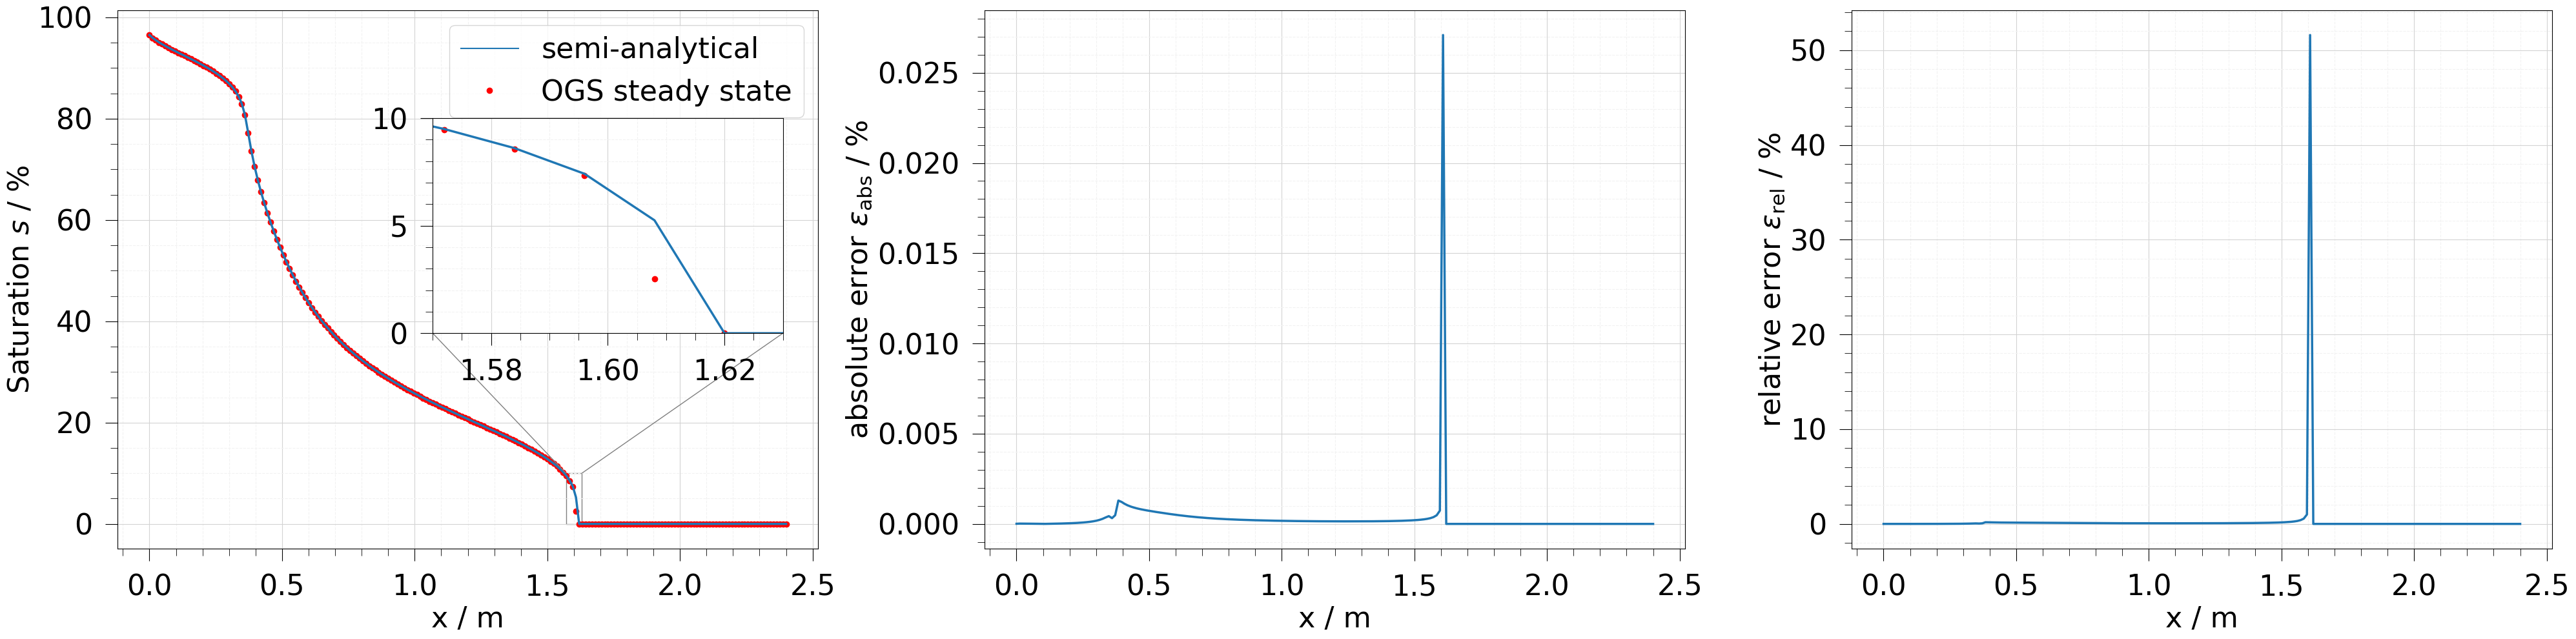

In [7]:
%%capture --no-display

fig, ax = plt.subplots(ncols=3, figsize=(40, 10))

ax[0].plot([], [], color="C0", label="semi-analytical")
ot.plot.line(
    results_saturation,
    saturation,
    ax=ax[0],
    marker="o",
    linestyle="",
    color="red",
    label="OGS steady state",
)
ot.plot.line(results_saturation, saturation.anasol, ax=ax[0])
ot.plot.line(results_saturation, saturation.abs_error, ax=ax[1])
ot.plot.line(results_saturation, saturation.rel_error, ax=ax[2])
fig.tight_layout()

ax_inset = inset_axes(
    ax[0],
    width="100%",
    height="100%",
    loc="center",
    bbox_to_anchor=[0.45, 0.4, 0.5, 0.4],
    bbox_transform=ax[0].transAxes,
)
ot.plot.line(
    results_saturation, saturation, ax=ax_inset, marker="o", linestyle="", color="red"
)
ot.plot.line(results_saturation, saturation.anasol, ax=ax_inset)

ax_inset.set(xlim=(1.57, 1.63), ylim=(0, 10), xlabel="", ylabel="")
patch, pp1, pp2 = mark_inset(ax[0], ax_inset, loc1=3, loc2=4, fc="none", ec="0.5")
pp1.loc2, pp2.loc2 = 2, 1

In [8]:
results_temperature = ot.MeshSeries.extract_probe(results, probe_points, temperature)

abs_error = np.abs(
    semi_ana_solution["temperature"] - results_temperature.point_data[temperature][0]
)

mask = np.isnan(semi_ana_solution["temperature"])
rel_error = np.abs(abs_error / (semi_ana_solution["temperature"]))

np.testing.assert_array_less(abs_error[~mask], 0.04)
np.testing.assert_array_less(rel_error[~mask], 0.01)

results_temperature.point_data[temperature.anasol.data_name] = semi_ana_solution[
    "temperature"
]
results_temperature.point_data[temperature.abs_error.data_name] = abs_error
results_temperature.point_data[temperature.rel_error.data_name] = rel_error

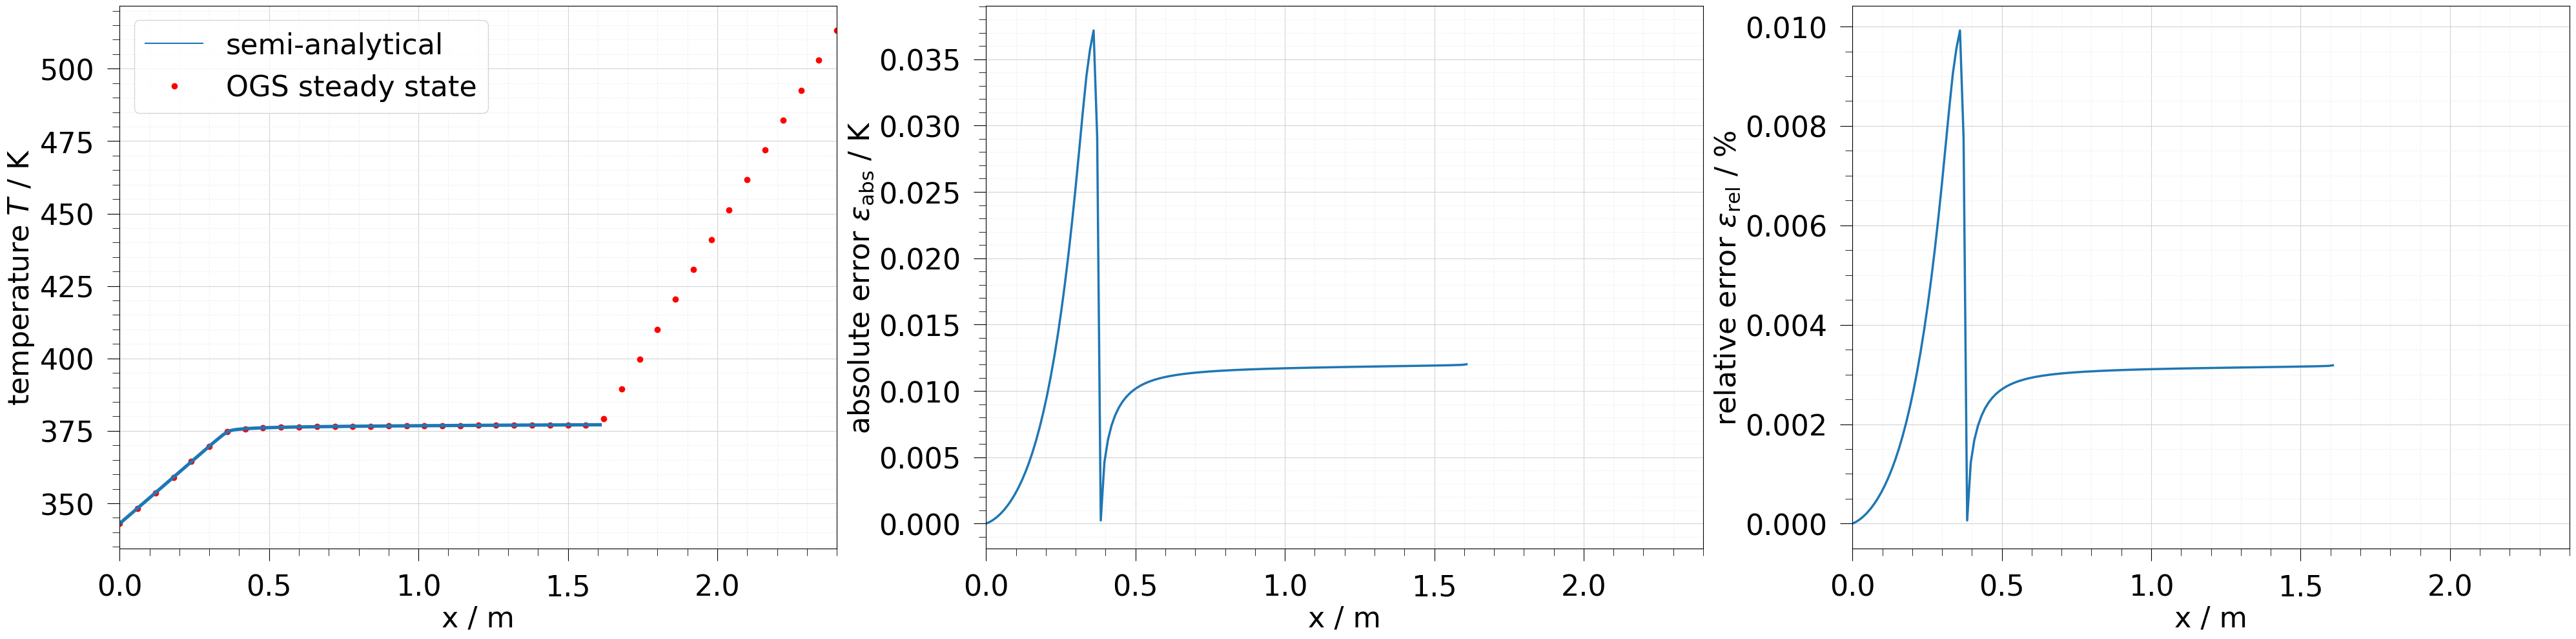

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(40, 10))

ax[0].plot([], [], color="C0", linewidth=1.5, label="semi-analytical")
ot.plot.line(
    results_temperature,
    temperature,
    ax=ax[0],
    marker="o",
    markersize=6,
    markevery=5,
    linestyle="",
    color="red",
    label="OGS steady state",
)
ot.plot.line(results_temperature, temperature.anasol, ax=ax[0], linewidth=1.5)
ot.plot.line(results_temperature, temperature.abs_error, ax=ax[1])
ot.plot.line(results_temperature, temperature.rel_error, ax=ax[2])
_ = [a.set_xlim(0, 2.4) for a in ax]

fig.tight_layout()

In [10]:
results_pressure = ot.MeshSeries.extract_probe(results, probe_points, pressure)

abs_error = np.abs(
    semi_ana_solution["pressure"] - results_pressure.point_data[pressure][0]
)

rel_error = np.zeros_like(semi_ana_solution["pressure"])
rel_error = np.abs(abs_error / (semi_ana_solution["pressure"]))

results_pressure.point_data[pressure.anasol.data_name] = semi_ana_solution["pressure"]
results_pressure.point_data[pressure.abs_error.data_name] = abs_error
results_pressure.point_data[pressure.rel_error.data_name] = rel_error

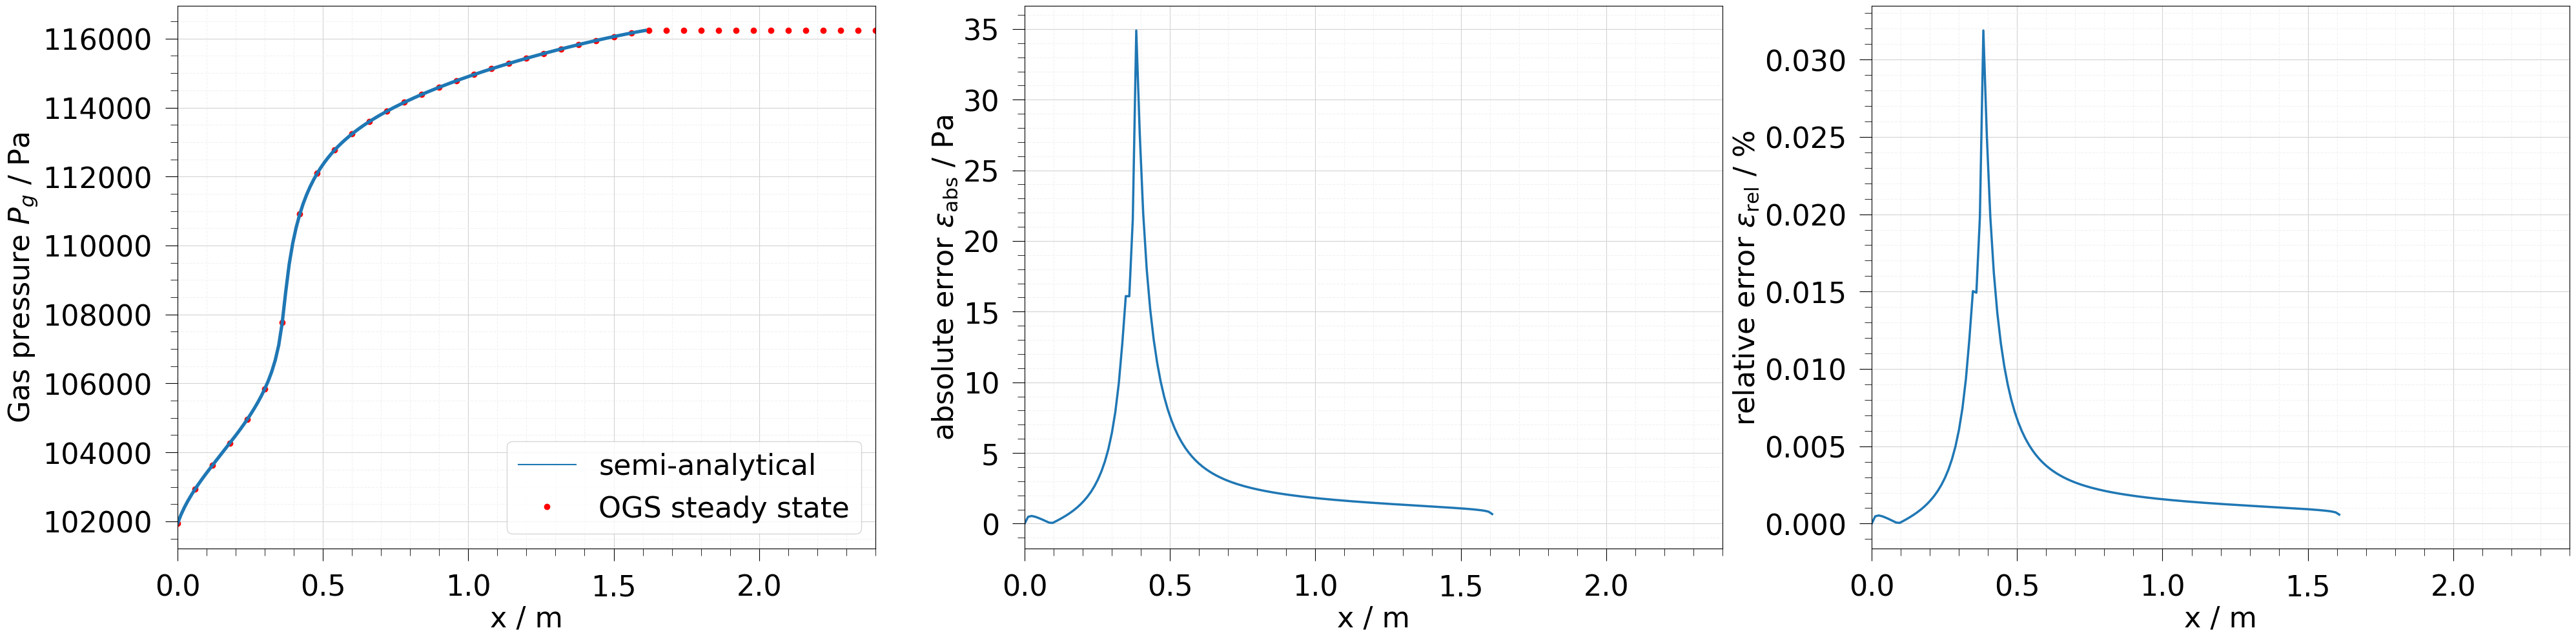

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(40, 10))

ax[0].plot([], [], color="C0", linewidth=1.5, label="semi-analytical")
ot.plot.line(
    results_pressure,
    pressure,
    ax=ax[0],
    marker="o",
    markevery=5,
    linestyle="",
    color="red",
    label="OGS steady state",
)
ot.plot.line(results_pressure, pressure.anasol, ax=ax[0], linewidth=1.5)
ot.plot.line(results_pressure, pressure.abs_error, ax=ax[1])
ot.plot.line(results_pressure, pressure.rel_error, ax=ax[2])
_ = [a.set_xlim(0, 2.4) for a in ax]

fig.tight_layout()

From the above results, it can be seen that a very good agreement is obtained with respect to the variables saturation, temperature and gas pressure, especially for the latter two.
For the saturation, there is only one data point that the divergence between numerical and semi-analytical solutions is obvious, which situates at the end of the two-phase zone (see the embedded subplot above).
This might be due to the sharp saturation change around this point which necessitates further mesh refinement locally.
Nevertheless, the extent of the heat pipe region at steady state was modeled accurately.
The disappearance of the water phase associated with a change of the phase state was carried out well.
Note that the OGS solution allows a region near the heated boundary to completely dry out, thus creating increased temperatures (superheated steam) in comparison to the semi-analytical results which assumes coexistence of the liquid and gas phases.

## References

[1] K. Udell and J. Fitch. Heat and mass transfer in capillary porous media considering evaporation, condensation, and non-condensible
gas effects. 23rd ASME/AIChE national heat transfer conference, Denver, CO. 1985, pp. 103-110.

[2] Leverett M et al. (1941) Capillary behavior in porous solids. Trans AIME 142(01):152-169

[3] Y. Huang, O. Kolditz, and H. Shao. Extending the persistent primary variable algorithm to simulate non-isothermal two-phase two-component flow with phase change phenomena. Geothermal Energy 3 (1) (2015). http://dx.doi.org/10.1186/s40517-015-0030-8.